2.6.0+cu126
True
1
NVIDIA GeForce GTX 1070
Using device: cuda


c:\Users\vojislav\Documents\projekti\MunjeLumenDS2025\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vojislav\Documents\projekti\MunjeLumenDS2025\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Loss: 3.3473
Train Metrics: {'accuracy': 0.7871481397630368, 'precision': 0.7053038852168305, 'recall': 0.988179491040506, 'f1': 0.823116239691449, 'auroc': np.float64(0.9103838365073158), 'auprc': np.float64(0.8904370850686305)}
Validation Metrics: {'accuracy': 0.752566425120773, 'precision': 0.6894997746732763, 'recall': 0.9214092140921409, 'f1': 0.7887614383296817, 'auroc': np.float64(0.8411682717425957), 'auprc': np.float64(0.8155498415463132)}
New best model found!
Epoch 2/20, Loss: 1.1134
Train Metrics: {'accuracy': 0.8089578145045657, 'precision': 0.7239458160367053, 'recall': 0.9993214204931011, 'f1': 0.839631307212315, 'auroc': np.float64(0.9570232779634759), 'auprc': np.float64(0.9425458471756719)}
Validation Metrics: {'accuracy': 0.7948369565217391, 'precision': 0.7238138895255558, 'recall': 0.9535024154589372, 'f1': 0.8229315960912053, 'auroc': np.float64(0.8788969969398353), 'auprc': np.float64(0.8515988951346724)}
New best model found!
Epoch 3/20, Loss: 0.7695

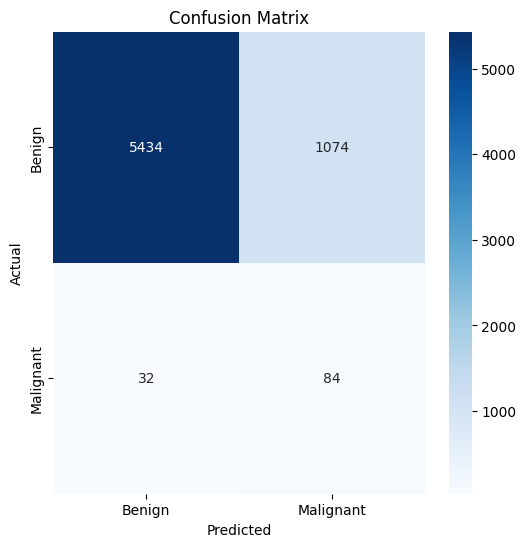

{'accuracy': 0.8330314009661836, 'precision': 0.07253886010362694, 'recall': 0.7241379310344828, 'f1': 0.13186813186813187, 'auroc': np.float64(0.8634512165398556), 'auprc': np.float64(0.1331623014021615)}
Training complete.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler
from torchvision.models import mobilenet_v3_large
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform_train = transforms.Compose(
    [
        # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

transform_val = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

dataset_path = "../data/dataset/train/"
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train_224", transform=transform_train)
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val_224", transform=transform_train)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/val_224", transform=transform_val)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    sampler=ImbalancedDatasetSampler(train_dataset),
    shuffle=False,
    num_workers=6,
    pin_memory=True,
    persistent_workers=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    sampler=ImbalancedDatasetSampler(val_dataset),
    shuffle=False,
    num_workers=6,
    pin_memory=True,
    persistent_workers=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=6,
    pin_memory=True,
    persistent_workers=True,
)
model = mobilenet_v3_large(pretrained=True)
num_ftrs = model.classifier[0].in_features


num_pos = sum(1 for _, label in train_dataset.samples if label == 1)
num_neg = sum(1 for _, label in train_dataset.samples if label == 0)
pos_weight = torch.tensor([num_neg / num_pos]).to(device)

model.classifier = nn.Sequential(nn.Linear(num_ftrs, 1))
model = model.to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)


def evaluate(model, dataloader):
    model.eval()
    y_true, y_scores = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images).squeeze()
            outputs = torch.sigmoid(outputs)
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    y_pred = (np.array(y_scores) > 0.5).astype(int)
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "auroc": roc_auc_score(y_true, y_scores),
        "auprc": average_precision_score(y_true, y_scores),
    }
    return metrics, y_true, y_pred


best_acc = float("-inf")
best_model = None
patience, counter = 5, 0
epochs = 20

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    val_metrics, y_true, y_pred = evaluate(model, val_loader)
    train_metrics, _, _ = evaluate(model, train_loader)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
    print(f"Train Metrics: {train_metrics}")
    print(f"Validation Metrics: {val_metrics}")

    scheduler.step(running_loss / len(train_loader))
    val_acc = val_metrics["accuracy"]
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = model.state_dict()
        counter = 0
        print("New best model found!")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

model.load_state_dict(best_model)
test_metrics, y_true, y_pred = evaluate(model, test_loader)


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Benign", "Malignant"],
        yticklabels=["Benign", "Malignant"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


plot_confusion_matrix(y_true, y_pred)
print(test_metrics)
print("Training complete.")